# Home Loan Approval/Denial: Exploratory Data Analysis & Processing

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

#### Auxiliary variables

In [2]:
filename_input = 'data-hdma-eastbay-2019-2022-preprocessed'
filename_output = 'data-hdma-eastbay-2019-2022-processed'
pos_label = "Approved"
neg_label = "Denied"

#### Auxiliary functions

In [3]:
def plot_success(df, col, xlabel, col_order=None, save=False, figsize=(5,4)):
    fig, ax = plt.subplots(figsize=figsize)

    sns.countplot(
        df,
        x=col,
        hue="application_outcome",
        hue_order=["Denied", "Approved"],
        order=col_order,
        ax=ax,
        stat="percent",
    )

    ax2 = ax.twinx()
    ct = pd.crosstab(df[col], df["application_outcome"], normalize="index")

    if col_order is None:
        col_order = [x.get_text() for x in ax.get_xticklabels()]
    ax2.plot(
        col_order,
        100 * ct.loc[col_order, pos_label],
        c="k",
        marker="o",
        label="Success rate",
    )

    ax.tick_params(axis="x", labelrotation=15)
    ax.set_xlabel(xlabel)
    ax2.set_ylabel("Success rate")
    ax2.set_ylim(
        100 * (ct.loc[:, pos_label].min() - 0.1),
        100 * (ct.loc[:, pos_label].max() + 0.2),
    )
    ax2.set_yticks([x for x in ax2.get_yticks() if x <= 100])
    # ax2.set_ylim(np.min([ct.loc[:, pos_label].min() - 0.1, 0.5]), np.max([ct.loc[:, pos_label].min() + 0.3, 1.4]))

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="best", framealpha=1.0)

    ax.grid()
    plt.tight_layout()
    if save:
        fig.savefig(f"images/analysis-{col}.png", dpi=600)

    return fig


def plot_success_numplot(df, col, xlabel, title, save=False, kind=None):
    fig, ax = plt.subplots(figsize=(5, 4))

    if kind == "kde":
        sns.histplot(
            df,
            x=col,
            hue="application_outcome",
            hue_order=["Denied", "Approved"],
            ax=ax,
            kde=True,
            bins=20,
            stat='percent',
        common_norm=False,
        )
    elif kind == "violin":
        sns.violinplot(
            df,
            x=col,
            hue="application_outcome",
            hue_order=["Denied", "Approved"],
            ax=ax,
        common_norm=False,
        )
    elif kind == "box":
        sns.boxplot(
            df,
            x=col,
            hue="application_outcome",
            hue_order=["Denied", "Approved"],
            ax=ax,
        )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid()
    plt.minorticks_on()
    plt.tight_layout()
    if save:
        plt.savefig(f"images/analysis-{col}.png", dpi=600)

    return fig


def plot_success_numerical2(df, col, xlabel, bins=5, q=False, lloc=2, save=False):
    fig, ax = plt.subplots(figsize=(5, 4))

    tdf = df.copy()
    if q:
        tdf[col] = pd.qcut(df[col], q=bins)
    else:
        tdf[col] = pd.cut(df[col], bins=bins)

    sns.histplot(
        df,
        x=col,
        hue="application_outcome",
        hue_order=["Denied", "Approved"],
        bins=bins,
        stat="percent",
        common_norm=False,
        ax=ax,
    )

    ct = pd.crosstab(tdf[col], tdf["application_outcome"], normalize="index")
    ax2 = ax.twinx()
    ax2.plot(
        [x.mid for x in ct.index.values],
        100 * ct.loc[:, pos_label].values,
        c="k",
        marker="o",
        label="Success rate",
    )

    ax.set_ylim((1.2 * x for x in ax.get_ylim()))

    ax.tick_params(axis="x", labelrotation=15)
    ax.set_xlabel(xlabel)
    ax2.set_ylabel("Success rate")
    ax2.set_ylim(np.min([ct.loc[:, pos_label].values.min() - 0.1, 0.5]), 1.1)
    ax2.set_ylim(
        100 * (ct.loc[:, pos_label].min() - 0.1),
        100 * (ct.loc[:, pos_label].max() + 0.15),
    )
    ax2.set_yticks([x for x in ax2.get_yticks() if x <= 100])

    ax2.legend(loc=lloc)
    plt.tight_layout()
    if save:
        plt.savefig(f"images/analysis-{col}.png", dpi=600)

    return fig


def plot_success_numerical(df, col, xlabel, bins=5, q=False, save=False):
    _, ax = plt.subplots(figsize=(6, 4))

    tdf = df.copy()
    if q:
        tdf[col] = pd.qcut(df[col], q=bins)
    else:
        tdf[col] = pd.cut(df[col], bins=bins)
    sns.countplot(tdf, x=col, hue="application_outcome", ax=ax)

    ax2 = ax.twinx()
    ct = pd.crosstab(tdf[col], tdf["application_outcome"], normalize="index")

    ax2.scatter(ct.index.astype(str), ct.loc[:, pos_label].values, c="k")

    ax.tick_params(axis="x", labelrotation=15)
    ax.set_xlabel(xlabel)
    ax2.set_ylabel("Application success rate")
    # ax2.set_ylim(np.min([ct.loc[:, pos_label].values.min() - 0.1, 0.5]), 1.1)
    ax2.set_ylim(ct.loc[:, pos_label].min() - 0.1, ct.loc[:, pos_label].max() + 0.2)

    plt.tight_layout()
    if save:
        plt.savefig(f"images/analysis-{col}.png", dpi=600)
    plt.show()

#### Loading the pre-processed data

In [4]:
df = pd.read_csv(f"../../{filename_input}.csv", index_col=0)

## Visualizing the data

### Feature distributions

application_outcome
Approved    469842
Denied       75002
Name: count, dtype: int64

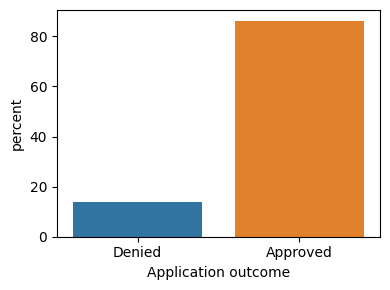

In [5]:
display(df['application_outcome'].value_counts())

plt.figure(figsize=(4,3))
sns.countplot(df, x='application_outcome', stat='percent', order=['Denied', 'Approved'], hue='application_outcome', hue_order=['Denied', 'Approved'])
plt.xlabel('Application outcome')
plt.tight_layout()
plt.savefig('images/target_feature-before_filter.png', dpi=600)
plt.show()

#### Denial reasons

In [6]:
# The denial_reason feature are all the individual denial reasons
# joined by ;. Here I am considering only the main reason for
# each application
df_denial = df['denial_reason'].apply(lambda x: x.split(';')[0])
df_denial = df_denial[df_denial != "not_applicable"]
df_denial = df_denial.value_counts(normalize=True)

df_denial

denial_reason
Debt-to-income ratio             0.384670
Credit application incomplete    0.161782
Credit history                   0.144769
Other                            0.114424
Collateral                       0.104171
Unverifiable information         0.055252
Insufficient cash                0.023866
Employment history               0.010933
Mortgage insurance denied        0.000133
Name: proportion, dtype: float64

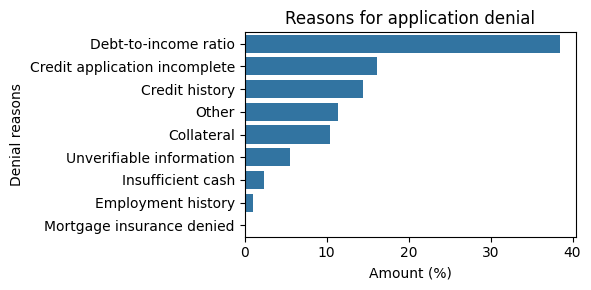

In [7]:
f, ax = plt.subplots(figsize=(6,3))

sns.barplot(y=df_denial.index, x=100*df_denial.values,orient='h')

plt.title('Reasons for application denial')
plt.xlabel('Amount (%)')
plt.ylabel('Denial reasons')

plt.tick_params(axis='both')
plt.tight_layout()
plt.savefig('images/analysis-denial_reason.png', dpi=600)
plt.show()

#### Purchaser type

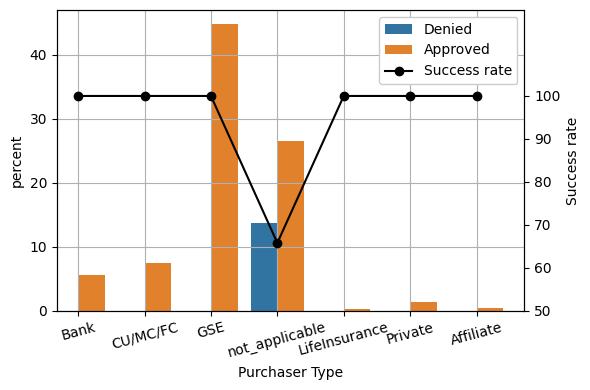

In [8]:
plot_success(df, "purchaser_type", "Purchaser Type", save=True, figsize=(6,4)).show()

In [9]:
df['purchaser_type'] = df['purchaser_type'].apply(lambda x: 'non-entity' if x == 'not_applicable' else 'entity')
df = df[df['purchaser_type'] == 'non-entity']
df = df.drop('purchaser_type', axis=1)

#### Target feature check

application_outcome
Approved    144265
Denied       75002
Name: count, dtype: int64

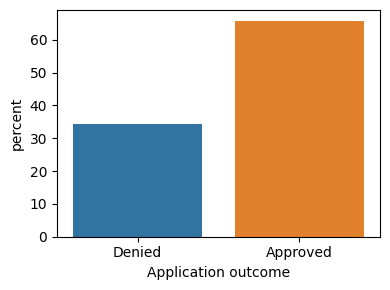

In [10]:
display(df['application_outcome'].value_counts())

plt.figure(figsize=(4,3))
sns.countplot(df, x='application_outcome', stat='percent', hue='application_outcome', hue_order=['Denied', 'Approved'])
plt.xlabel('Application outcome')
plt.tight_layout()
plt.savefig('images/target_feature.png', dpi=600)
plt.show()

#### Debt/income ratio

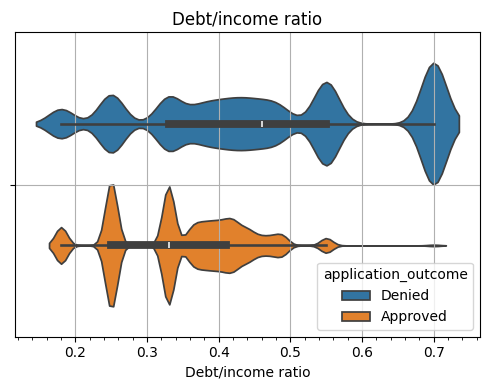

In [11]:
# f, ax = plt.subplots(figsize=(5,5))
# sns.violinplot(df, x='debt_to_income_ratio', hue='application_outcome', hue_order=['Denied', 'Approved'], ax=ax)

# ax.set_title('Debt/income ratio for approved/denied applications')
# ax.set_xlabel('Debt/income ratio')
# plt.minorticks_on()
# plt.tight_layout()
# plt.show()

plot_success_numplot(
    df,
    "debt_to_income_ratio",
    "Debt/income ratio",
    "Debt/income ratio",
    save=True,
    kind="violin",
).show()

#### Occupancy type

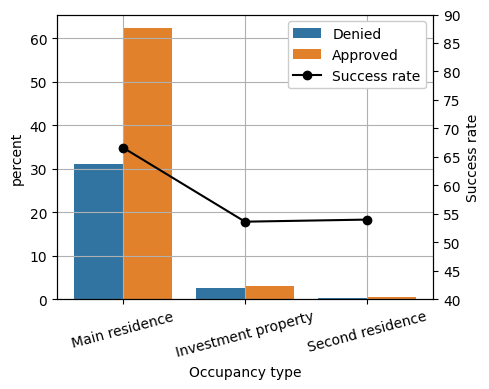

In [12]:
plot_success(df, "occupancy_type", "Occupancy type").show()

#### Loan/value ratio

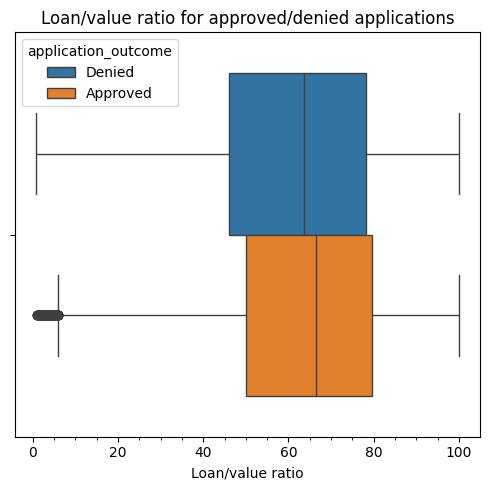

In [13]:
# plot_success_numerical(df, "loan_to_value_ratio", "Loan/Value Ratio", bins=4, q=True, save=True)

f, ax = plt.subplots(figsize=(5,5))
sns.boxplot(df, x='loan_to_value_ratio', hue='application_outcome', hue_order=['Denied', 'Approved'], ax=ax)

ax.set_title('Loan/value ratio for approved/denied applications')
ax.set_xlabel('Loan/value ratio')
plt.minorticks_on()
plt.tight_layout()
plt.show()

#### Other

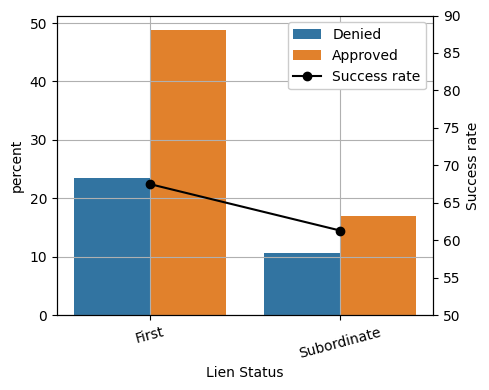

In [14]:
plot_success(df, "lien_status", "Lien Status").show()

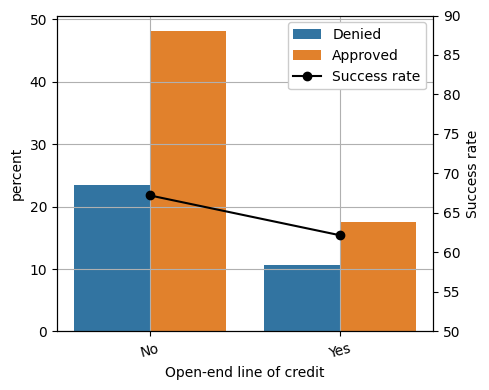

In [15]:
plot_success(df, "open-end_line_of_credit", "Open-end line of credit").show()

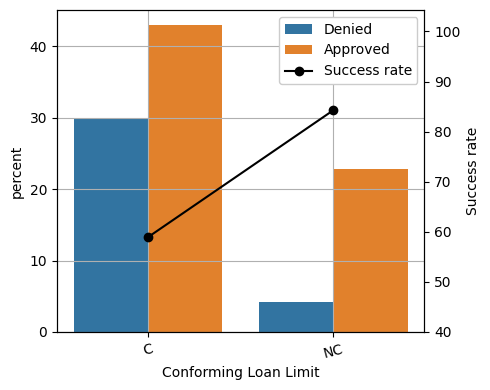

In [16]:
plot_success(df, "conforming_loan_limit", "Conforming Loan Limit").show()

#### Applicant's age

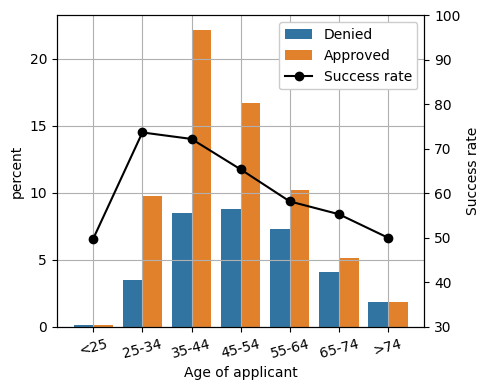

In [17]:
plot_success(
    df,
    "applicant_age",
    "Age of applicant",
    col_order=["<25", "25-34", "35-44", "45-54", "55-64", "65-74", ">74"],
    save=True,
).show()

#### Applicant's sex

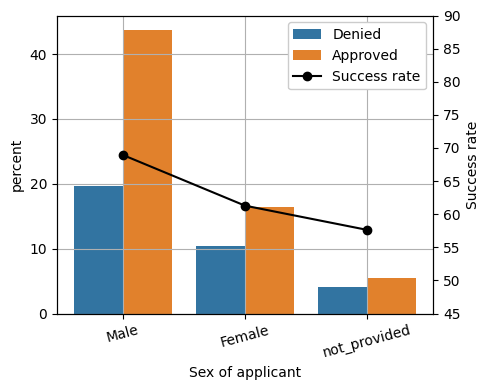

In [18]:
plot_success(df, "applicant_sex", "Sex of applicant", save=True).show()

#### Applicant's race

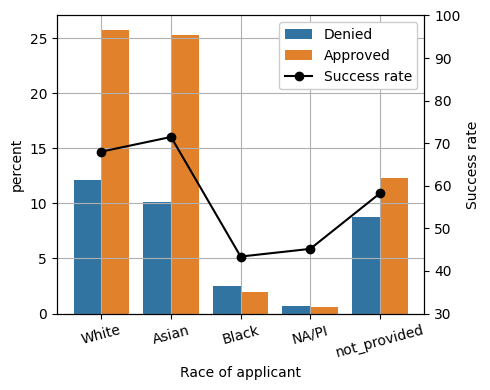

In [19]:
fig = plot_success(
    df,
    "applicant_race",
    "Race of applicant",
    col_order=['White', 'Asian', 'Black', 'NA/PI', 'not_provided'],
    save=True,
).show()

#### Applicant's ethnicity

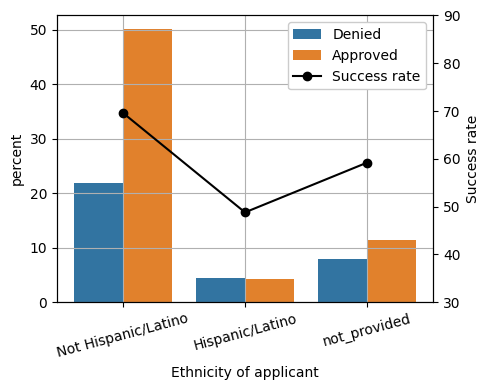

In [20]:
plot_success(df, "applicant_ethnicity", "Ethnicity of applicant", save=True).show()

#### Loan purpose

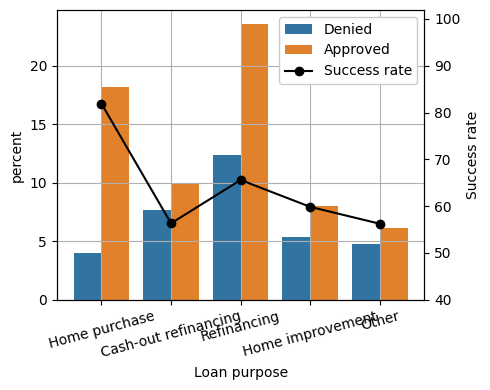

In [21]:
plot_success(df, "loan_purpose", "Loan purpose", save=True).show()

#### Loan type

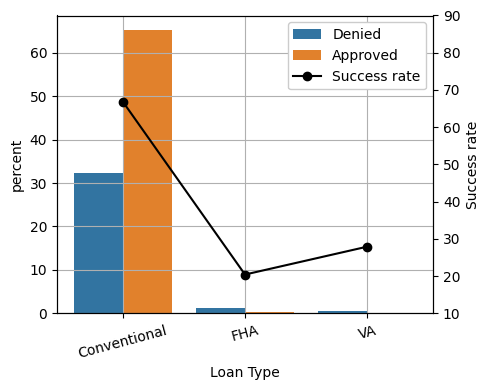

In [22]:
plot_success(df, "loan_type", "Loan Type").show()

#### Income

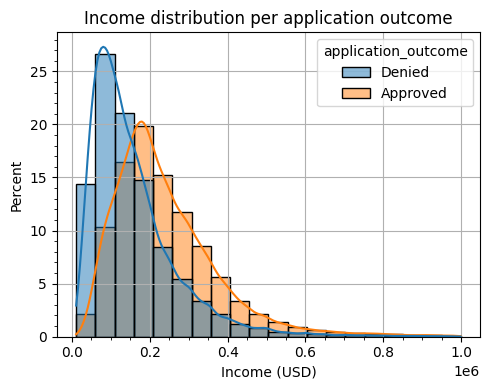

In [23]:
fig = plot_success_numplot(
    df,
    "income",
    xlabel="Income (USD)",
    title="Income distribution per application outcome",
    save=True,
    kind='kde',
)
fig.show()

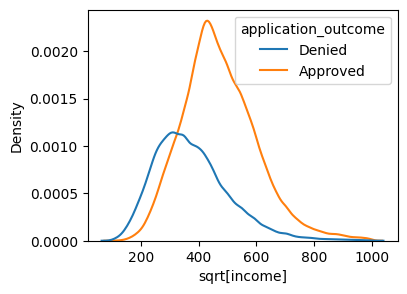

In [24]:
f, ax = plt.subplots(figsize=(4,3))
sns.kdeplot(df[['income']].apply(np.sqrt), x='income', hue=df['application_outcome'], ax=ax)
plt.xlabel('sqrt[income]')
plt.show()

#### Property value

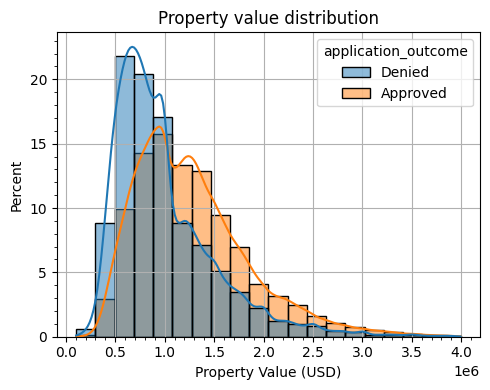

In [25]:
plot_success_numplot(
    df,
    "property_value",
    xlabel="Property Value (USD)",
    title="Property value distribution",
    save=True,
    kind='kde',
).show()

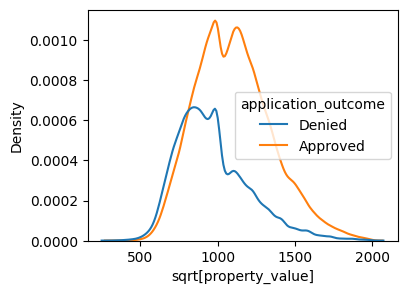

In [26]:
f, ax = plt.subplots(figsize=(4,3))
sns.kdeplot(df[['property_value']].apply(np.sqrt), x='property_value', hue=df['application_outcome'], ax=ax)
plt.xlabel('sqrt[property_value]')
plt.show()

#### Loan amount

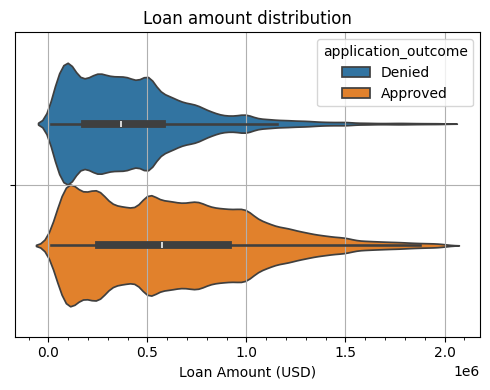

In [27]:
plot_success_numplot(
    df,
    "loan_amount",
    xlabel="Loan Amount (USD)",
    title="Loan amount distribution",
    save=True,
    kind='violin',
).show()

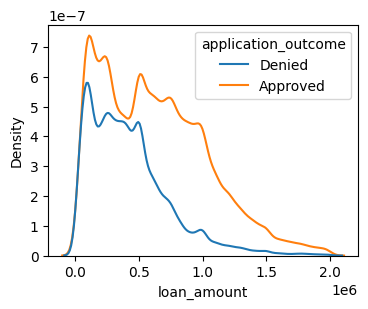

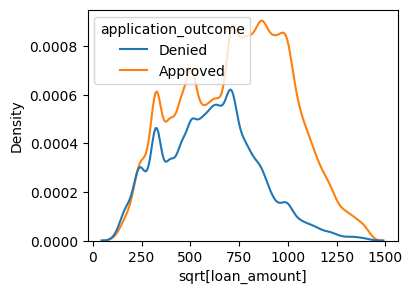

In [28]:
f, ax = plt.subplots(figsize=(4,3))
sns.kdeplot(df[['loan_amount']], x='loan_amount', hue=df['application_outcome'], ax=ax)
plt.show()

f, ax = plt.subplots(figsize=(4,3))
sns.kdeplot(df[['loan_amount']].apply(np.sqrt), x='loan_amount', hue=df['application_outcome'], ax=ax)
plt.xlabel('sqrt[loan_amount]')
plt.show()

#### Loan term

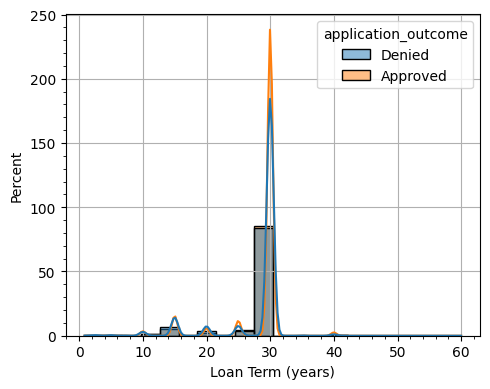

In [29]:
# tdf = df[["loan_term", "application_outcome"]].copy()
# tdf["loan_term"] = np.array([int(x) for x in tdf.loc[:, "loan_term"].values])
# tdf["loan_term"].value_counts()
# plot_success_numerical(tdf, "loan_term", "Loan Term (years)", bins=4, q=False)

plot_success_numplot(
    df,
    "loan_term",
    xlabel="Loan Term (years)",
    title="",
    kind='kde',
).show()

#### Census information

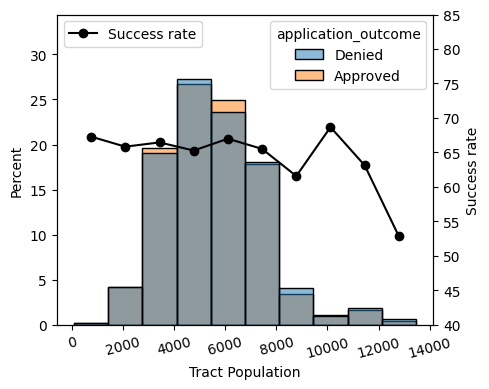

In [30]:
plot_success_numerical2(
    df, "tract_population", "Tract Population", bins=10,
    save=False,
).show()

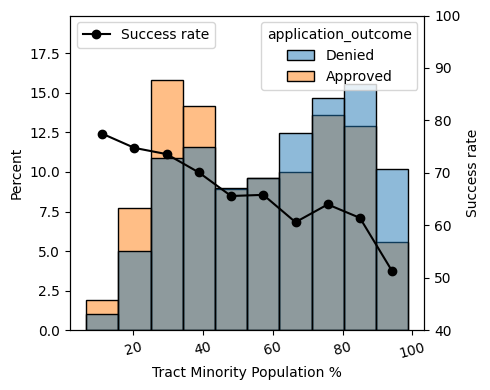

In [31]:
plot_success_numerical2(
    df, "tract_minority_population_percent", "Tract Minority Population %", bins=10,
    save=True,
).show()

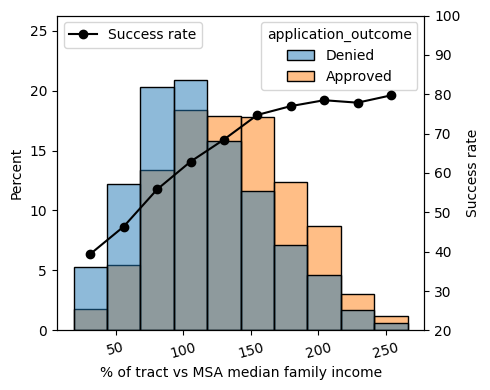

In [32]:
plot_success_numerical2(
    df, "tract_to_msa_income_percentage", "% of tract vs MSA median family income", bins=10, save=True, lloc=2,
).show()

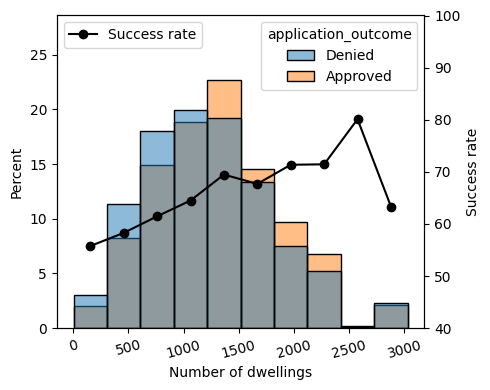

In [33]:
plot_success_numerical2(
    df, "tract_owner_occupied_units", "Number of dwellings", bins=10
).show()

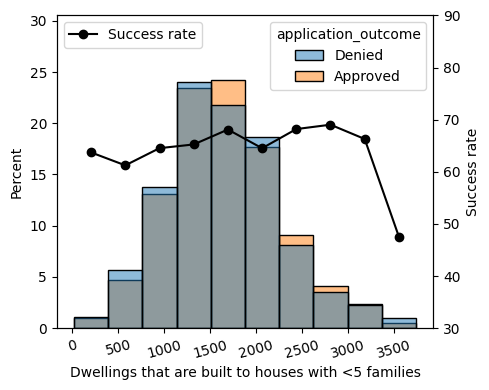

In [34]:
plot_success_numerical2(
    df, "tract_one_to_four_family_homes", "Dwellings that are built to houses with <5 families", bins=10
).show()

#### Derived features

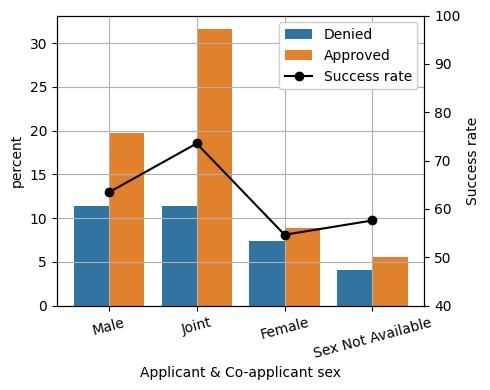

In [35]:
plot_success(df, 'derived_sex', xlabel='Applicant & Co-applicant sex', save=True).show()

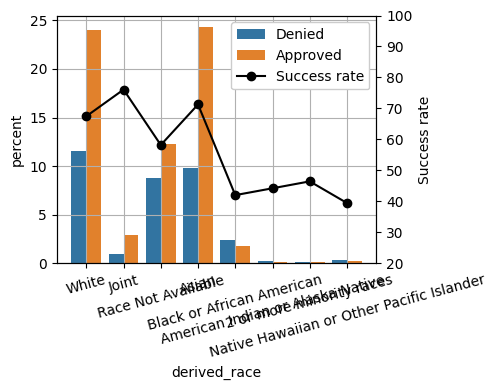

In [36]:
plot_success(df, 'derived_race', xlabel='derived_race').show()

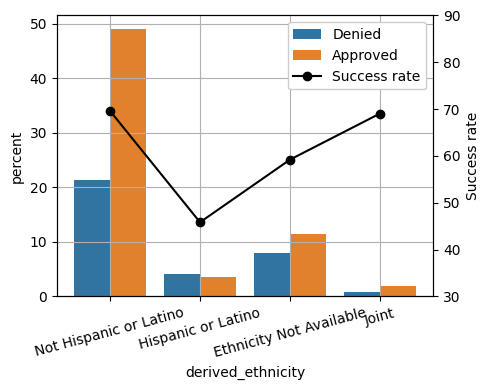

In [37]:
plot_success(df, 'derived_ethnicity', xlabel='derived_ethnicity').show()

### Correlation

In [38]:
corr_map = df.select_dtypes(float).copy()
corr_map['outcome'] = df['application_outcome'].map({'Approved': 1, 'Denied': 0})
corr_map = corr_map.corr().abs()

upper = corr_map.where(np.triu(np.ones(corr_map.shape), k=1).astype(bool))
[column for column in upper.columns if any(upper[column] > 0.70)]

['tract_one_to_four_family_homes', 'tract_owner_occupied_units']

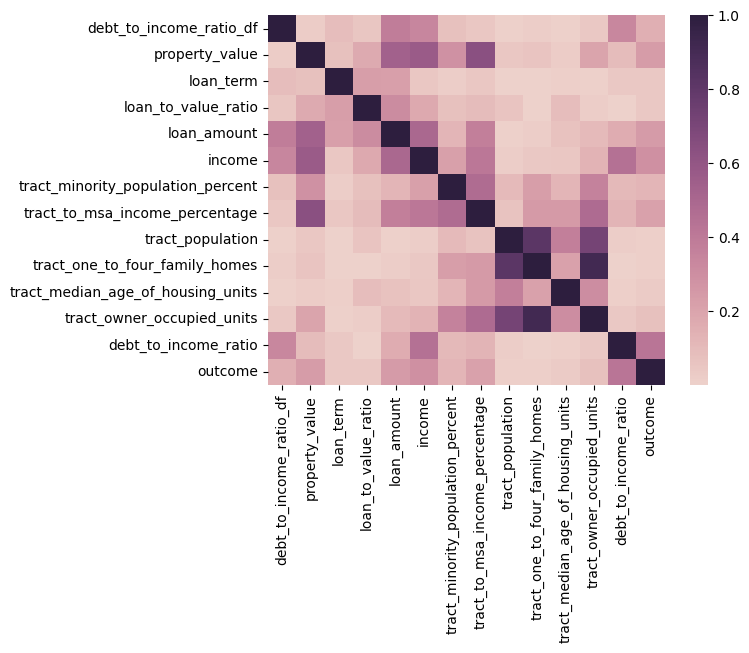

In [39]:
sns.heatmap(corr_map, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

### Crosstabulation

In [40]:
def crosstab_and_chi2(A, B):
    crosstab = pd.crosstab(index=A, columns=B)
    chi2 = chi2_contingency(crosstab)

    display(crosstab)
    print(f'{A.name} p-value={chi2[1]}')

In [41]:
for col in df.select_dtypes(object).columns.tolist():
    crosstab_and_chi2(df[col], df['application_outcome'])

application_outcome,Approved,Denied
applicant_age_above_62,,
No,123749,57803
Yes,20516,17199


applicant_age_above_62 p-value=0.0


application_outcome,Approved,Denied
denial_reason,,
Collateral,0,6462
Collateral;Credit application incomplete,0,66
Collateral;Credit application incomplete;Debt-to-income ratio,0,1
Collateral;Credit application incomplete;Other,0,6
Collateral;Credit history,0,36
...,...,...
Unverifiable information;Mortgage insurance denied;Other;Credit history,0,1
Unverifiable information;Other,0,190
Unverifiable information;Other;Employment history,0,1


denial_reason p-value=0.0


application_outcome,Approved,Denied
applicant_race,,
Asian,55406,22116
Black,4261,5562
NA/PI,1205,1462
White,56509,26561
not_provided,26884,19301


applicant_race p-value=0.0


application_outcome,Approved,Denied
coapplicant_age,,
25-34,14456,3880
35-44,26749,7967
45-54,18621,7712
55-64,12004,6400
65-74,6421,3616
<25,228,236
>74,1856,1380
no_coapplicant,63930,43811


coapplicant_age p-value=0.0


application_outcome,Approved,Denied
coapplicant_race,,
Asian,28694,9742
Black,1602,1398
NA/PI,676,514
White,32843,11063
no_coapplicant,63929,43804
not_provided,16521,8481


coapplicant_race p-value=0.0


application_outcome,Approved,Denied
applicant_age,,
25-34,21395,7633
35-44,48468,18621
45-54,36534,19323
55-64,22299,16013
65-74,11185,9032
<25,282,284
>74,4102,4096


applicant_age p-value=0.0


application_outcome,Approved,Denied
applicant_ethnicity,,
Hispanic/Latino,9353,9817
Not Hispanic/Latino,109827,47903
not_provided,25085,17282


applicant_ethnicity p-value=0.0


application_outcome,Approved,Denied
coapplicant_sex,,
Female,54290,19362
Male,18535,7890
no_coapplicant,63931,43804
not_provided,7509,3946


coapplicant_sex p-value=0.0


application_outcome,Approved,Denied
conforming_loan_limit,,
C,94118,65652
NC,50147,9350


conforming_loan_limit p-value=0.0


application_outcome,Approved,Denied
coapplicant_ethnicity,,
Hispanic/Latino,5379,3862
Not Hispanic/Latino,59655,19675
no_coapplicant,63919,43803
not_provided,15312,7662


coapplicant_ethnicity p-value=0.0


application_outcome,Approved,Denied
interest_only_payment,,
No,120337,66338
Yes,23928,8664


interest_only_payment p-value=7.435427689552943e-217


application_outcome,Approved,Denied
hoepa_status,,
No,135778,0
not_applicable,8487,75002


hoepa_status p-value=0.0


application_outcome,Approved,Denied
business_or_commercial_purpose,,
No,140259,72269
Yes,4006,2733


business_or_commercial_purpose p-value=7.437460679379326e-29


application_outcome,Approved,Denied
open-end_line_of_credit,,
No,105710,51551
Yes,38555,23451


open-end_line_of_credit p-value=4.01661004239174e-111


application_outcome,Approved,Denied
lien_status,,
First,107092,51550
Subordinate,37173,23452


lien_status p-value=2.5583008070448612e-164


application_outcome,Approved,Denied
loan_purpose,,
Cash-out refinancing,21763,16870
Home improvement,17506,11744
Home purchase,39807,8787
Other,13451,10464
Refinancing,51738,27137


loan_purpose p-value=0.0


application_outcome,Approved,Denied
loan_type,,
Conventional,143069,70927
FHA,756,2940
VA,440,1135


loan_type p-value=0.0


application_outcome,Approved,Denied
application_outcome,,
Approved,144265,0
Denied,0,75002


application_outcome p-value=0.0


application_outcome,Approved,Denied
derived_sex,,
Female,19466,16142
Joint,69268,24913
Male,43404,25030
Sex Not Available,12127,8917


derived_sex p-value=0.0


application_outcome,Approved,Denied
derived_race,,
2 or more minority races,283,326
American Indian or Alaska Native,407,513
Asian,53237,21436
Black or African American,3869,5336
Joint,6476,2035
Native Hawaiian or Other Pacific Islander,441,676
Race Not Available,26884,19301
White,52668,25379


derived_race p-value=0.0


application_outcome,Approved,Denied
derived_ethnicity,,
Ethnicity Not Available,25085,17282
Hispanic or Latino,7612,8997
Joint,4063,1820
Not Hispanic or Latino,107505,46903


derived_ethnicity p-value=0.0


application_outcome,Approved,Denied
derived_loan_product_type,,
Conventional:First Lien,105898,47481
Conventional:Subordinate Lien,37171,23446
FHA:First Lien,755,2934
FHA:Subordinate Lien,1,6
VA:First Lien,439,1135
VA:Subordinate Lien,1,0


derived_loan_product_type p-value=0.0


application_outcome,Approved,Denied
applicant_sex,,
Female,36169,22848
Male,95969,43237
not_provided,12127,8917


applicant_sex p-value=0.0


application_outcome,Approved,Denied
occupancy_type,,
Investment property,6657,5756
Main residence,136574,68365
Second residence,1034,881


occupancy_type p-value=6.998203128127743e-218


## Exporting processed data

In [42]:
df.to_csv(f'../../{filename_output}.csv')